In [4]:
!pip install mne

# from google.colab import drive
# drive.mount('/content/drive/')

import mne
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 9.3 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 KB 5.5 MB/s eta 0:00:00


In [ ]:
import torch
#import time
#torch.set_num_threads(1)
#t = time.time()
torch.ones((10, 10))# + torch.ones((10, 10))
#print(time.time() - t)

In [76]:
DATA_PATH = './'

train_A_raw = scipy.io.loadmat(DATA_PATH + 'Subject_A_Train.mat')
train_B_raw = scipy.io.loadmat(DATA_PATH + 'Subject_B_Train.mat')
test_A_raw = scipy.io.loadmat(DATA_PATH + 'Subject_A_Test.mat')
test_B_raw = scipy.io.loadmat(DATA_PATH + 'Subject_B_Test.mat')

eloc = mne.channels.read_custom_montage(DATA_PATH + 'eloc64.loc')

Creating RawArray with float64 data, n_channels=64, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


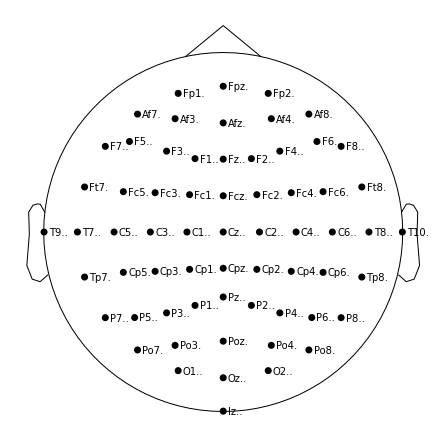

In [77]:
t = eloc.plot()

In [78]:
def p300_set(raw_data, is_flashing=True):
    X = []
    y = []

    for epoch_num in range(len(raw_data['Flashing'])):
        epoch_flash = raw_data['Flashing'][epoch_num]
        idx = np.where(epoch_flash[:-1] != epoch_flash[1:])[0] + 1

        res = np.split(raw_data['Signal'][epoch_num], idx, axis=0)
        target = raw_data['StimulusType'][epoch_num][np.insert(idx, 0, 0)]

        if is_flashing:
            res = res[::2]
            target = target[::2]

        X.append(res)
        y.append(target)

    return np.concatenate(X), np.concatenate(y)

In [79]:
X_train_A, y_train_A = p300_set(train_A_raw)
X_train_B, y_train_B = p300_set(train_B_raw)
X_test_A, y_test_A = p300_set(test_A_raw)
X_test_B, y_test_B = p300_set(test_B_raw)

KeyError: 'StimulusType'

In [10]:
def to_tensor(X_train, y_train):
    X_train = torch.tensor(X_train).transpose(1,2)
    y_train = torch.tensor(y_train)

    return X_train, y_train

In [11]:
X_train_A, y_train_A = to_tensor(X_train_A, y_train_A)
X_train_B, y_train_B = to_tensor(X_train_B, y_train_B)

X_test_A, y_test_A = to_tensor(X_test_A, y_test_A)
X_test_B, y_test_B = to_tensor(X_test_B, y_test_B)

In [12]:
class EEGDataset(Dataset):
    """
    TensorDataset with support of transforms.
    """
    def __init__(self, tensors, with_target=True, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform
        self.with_target = with_target

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        if self.with_target:
            y = self.tensors[1][index]
            return x, y
        else:
            return x

    def __len__(self):
        return self.tensors[0].size(0)

In [13]:
train_A_dataset = EEGDataset(tensors=(X_train_A, y_train_A), with_target=False, transform=None)
train_B_dataset = EEGDataset(tensors=(X_train_B, y_train_B), with_target=False, transform=None)
test_A_dataset = EEGDataset(tensors=(X_test_A, y_test_A), with_target=False, transform=None)
test_B_dataset = EEGDataset(tensors=(X_test_B, y_test_B), with_target=False, transform=None)

train_A_CNN = DataLoader(train_A_dataset, batch_size=4)
train_B_CNN = DataLoader(train_B_dataset, batch_size=4)
test_A_CNN = DataLoader(test_A_dataset, batch_size=4)
test_B_CNN = DataLoader(test_B_dataset, batch_size=4)

In [17]:
X_train_A.shape, y_train_A.shape

(torch.Size([15300, 64, 24]), torch.Size([15300]))

In [58]:
from sklearn.neighbors import KNeighborsClassifier as KNN
class TimeSeriesKNN:
    def __init__(self, **kwargs):
        self.knn = KNN(**kwargs)

    def fit(self, X: np.array, y: np.array):
        self.size = min([arr.shape[1] for arr in X])
        data = np.concatenate([arr[:, : self.size].reshape(1,-1) for arr in X], axis=0)
        self.knn.fit(data, y)

    def predict(self, X: np.array):
        if isinstance(X, list) or len(X.shape) == 3:
            data = np.concatenate([arr[:, : self.size].reshape(1,-1) for arr in X], axis=0)
            return self.knn.predict(data)
        else:
            return self.knn.predict(X.reshape(1, -1))

    def predict_proba(self, X):
        if isinstance(X, list) or len(X.shape) == 3:
            data = np.concatenate([arr[:, : self.size].reshape(1,-1) for arr in X], axis=0)
            return self.knn.predict_proba(data)
        else:
            return self.knn.predict_proba(X.reshape(-1,1))

In [73]:
from sklearn.metrics import accuracy_score as acc
knn = TimeSeriesKNN(n_neighbors=1)
knn.fit(X_train_A, y_train_A)
print('Accuracy KNN for earthquake dataset: %f' % (acc(y_test_A, knn.predict(X_test_A))))

Accuracy KNN for earthquake dataset: 1.000000


In [74]:
1 - y_test_A.mean()

tensor(0.8333)